Inpendencies

In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from natsort import natsorted
from sklearn.metrics.pairwise import cosine_similarity

# Preprocessing

In [2]:
def get_hist(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    return hist

def visualize_hist(hist):
    plt.figure()
    plt.title("Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.plot(hist)
    plt.xlim([0, 256])
    plt.show()

Label mapping

In [8]:
label_mapping = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
reverse_mapping = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

DATA_PATH = "./dataset/seg"
TEST_PATH = "./dataset/seg_test"

Extract Histogram

In [28]:
infos = []
features = []
for label in os.listdir(DATA_PATH):
    class_path = os.path.join(DATA_PATH, label)
    for im in tqdm(natsorted(os.listdir(class_path)), desc=f'processing {label}:'):
        if im.endswith('jpg'):
            im_path = os.path.join(class_path, im)
            infos.append([os.path.splitext(im)[0], label_mapping[label]])
            features.append(get_hist(im_path).flatten())
infos = np.array(infos)
features = np.array(features, dtype = np.int32)

processing street:: 100%|██████████| 2382/2382 [00:17<00:00, 136.57it/s]


In [365]:
# save to npy
np.save(os.path.join("./save/", "infos.npy"), infos)
np.save(os.path.join("./save/", "features.npy"), features)

In [5]:
# load npy
infos = np.load("./save/infos.npy")
features = np.load("./save/features.npy")

# Retrieve

In [146]:
def search_engine(im_query_path, features, top_k=10, compare_method = "cosine_similarity"):
    hist_query = get_hist(im_query_path).flatten().astype(np.int32)

    # calc distance
    if compare_method == "cosine_similarity":
        similarities = cosine_similarity([hist_query], features).flatten()
        top_k_idx = similarities.argsort()[-top_k:][::-1]

    elif compare_method == "eculidean_distance":
        similarities = np.sqrt(np.sum((features - [hist_query]) ** 2, axis=1))
        top_k_idx = similarities.argsort()[:top_k]

    else:
        raise Exception("The method must 'cosine_similarity' or 'eculidean_distance'!")

    # get top k
    top_k_im = infos[top_k_idx].copy()
    top_k_im[:, 1] = list(map(lambda x: reverse_mapping[int(x)], top_k_im[:, 1]))
    return top_k_im

In [166]:
def visualize_res(search_result):
    plt.figure(figsize=(15, 10))
    for idx, result in enumerate(search_result):
        im_name = result[0]
        label = result[1]

        image = cv2.imread(os.path.join(DATA_PATH, label, f"{im_name}.jpg"))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.subplot(len(search_result) // 5 + 1, 5, idx + 1)
        plt.imshow(image)
        plt.title(f"{label}: {im}")
        plt.axis("off")

    plt.show()

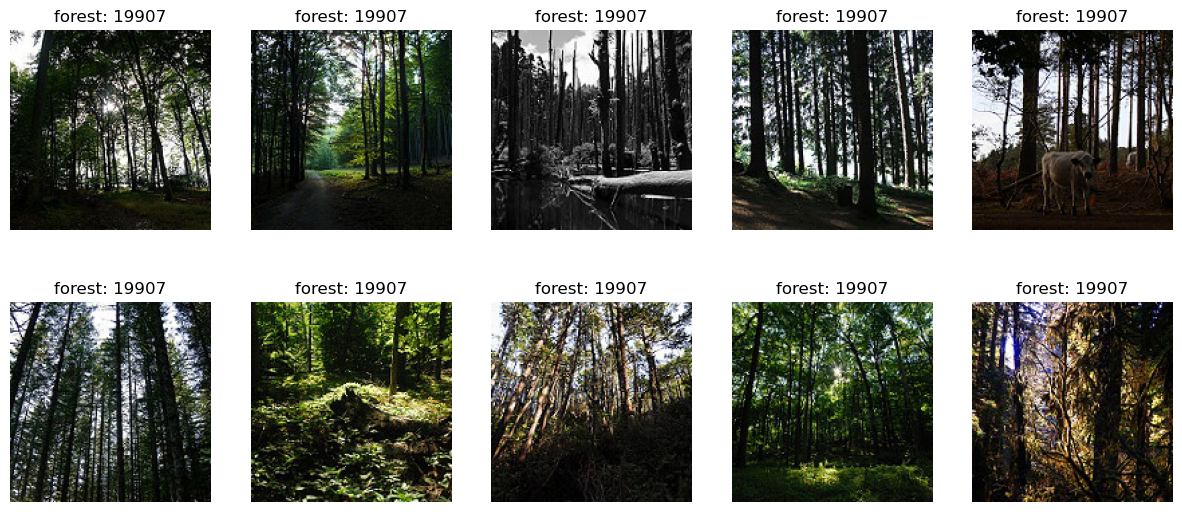

In [168]:
visualize_res(search_engine(".\dataset\seg_test\\forest\\20091.jpg", features, compare_method='eculidean_distance'))